# Compare different Rllib Algorithms

- Rllib provides a set of RL algorithms: [Algorithms](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html)
- They can be used with the default configuration
- Or with a customized configuration

## Available Algorithms - Overview

[Github Directory Algorithms](https://github.com/ray-project/ray/tree/master/rllib/algorithms)

<img src="../figures/rllib_available_algorithms_overview.png" width=800>

In [47]:
import gym, ray
from ray.tune.registry import register_env
from ray_trading_env import RayTradingEnvironment

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# import some agents
from ray.rllib.agents.a3c import A3CTrainer
from ray.rllib.agents.dqn import DQNTrainer
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.agents.sac import SACTrainer

In [2]:
# instantiate ray
ray.init()

2022-06-27 20:33:47,915	WARNING services.py:2002 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67096576 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


RayContext(dashboard_url='', python_version='3.8.8', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '10.1.150.226', 'raylet_ip_address': '10.1.150.226', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-06-27_20-33-46_331525_66998/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-06-27_20-33-46_331525_66998/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-06-27_20-33-46_331525_66998', 'metrics_export_port': 59877, 'gcs_address': '10.1.150.226:59803', 'address': '10.1.150.226:59803', 'node_id': '5ac0469abe9e9d1a9d775e98331d4ab7ab5a956451d50042dfa73ede'})

### Register Custom Env

In [3]:
def env_creator(env_config):
    return RayTradingEnvironment()

In [39]:
# register the custum env
register_env("RayTradingEnv", env_creator)

### Instantiate Trainer Instances

In [66]:
# instantiate trainer
a3c_trainer = A3CTrainer(env="RayTradingEnv")
ppo_trainer = PPOTrainer(env="RayTradingEnv")
dqn_trainer = DQNTrainer(env="RayTradingEnv")
#sac_trainer = SACTrainer(env="RayTradingEnv")

(RolloutWorker pid=70589) INFO:ray_trading_env:ray_trading_env logger started.
(RolloutWorker pid=70590) INFO:ray_trading_env:ray_trading_env logger started.
(RolloutWorker pid=70589) INFO:ray_trading_env:got data for AAPL...
(RolloutWorker pid=70589) /opt/conda/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=70589)   logger.warn(
(RolloutWorker pid=70589) 2022-06-27 21:38:18,599	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=70590) INFO:ray_trading_env:got data for AAPL...
(RolloutWorker pid=70590) /opt/conda/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=70590)   logger.w

### Train Policies and collect results

In [7]:
def training_loop(trainer, n_episodes=100):
    results_list = []
    trainer = trainer
    for _ in range(100):
        # print dots to keep track of training
        print('.', end="")
        results = trainer.train()
        #print(f"Iteration={rllib_trainer.iteration}: R(\"return\")={results['episode_reward_mean']}")
        episode_mean_reward = results['episode_reward_mean']
        episode = trainer.iteration
        results_list.append(np.array([episode, episode_mean_reward]))

    result_array = np.array(results_list)
    return result_array

In [11]:
ppo_results = training_loop(trainer=ppo_trainer, n_episodes=100)

....................................................................................................

In [42]:
a3c_results = training_loop(trainer=a3c_trainer, n_episodes=100)

....................................................................................................

In [58]:
dqn_results = training_loop(trainer=dqn_trainer, n_episodes=100)

2022-06-27 21:27:24,702	WARNING deprecation.py:46 -- DeprecationWarning: `ReplayBuffer.add_batch()` has been deprecated. Use `RepayBuffer.add()` instead. This will raise an error in the future!
2022-06-27 21:27:24,713	WARNING multi_agent_prioritized_replay_buffer.py:186 -- Adding batches with column `weights` to this buffer while providing weights as a call argument to the add method results in the column being overwritten.
2022-06-27 21:27:24,714	WARNING deprecation.py:46 -- DeprecationWarning: `replay` has been deprecated. Use `sample` instead. This will raise an error in the future!


....................................................................................................

### Plot Results

In [61]:
result_dict = {'PPO':ppo_results,'A3C':a3c_results, 'DQN':dqn_results}

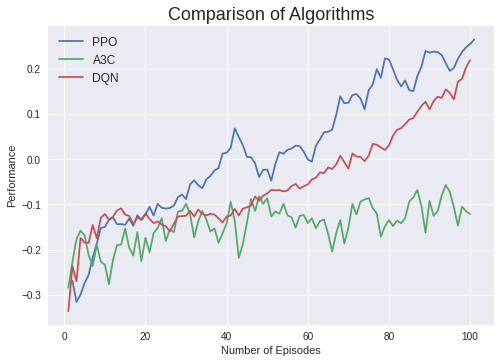

In [67]:
#plot
for key, result_array in result_dict.items():
    x = result_array[:,0]
    y = result_array[:,1]
    plt.plot(x,y, label=key)

plt.title("Comparison of Algorithms",fontsize=18)
plt.legend(fontsize=12)
plt.xlabel('Number of Episodes')
plt.ylabel('Performance')
plt.show()

### Close Session

In [69]:
a3c_trainer.stop()
ppo_trainer.stop()
dqn_trainer.stop()
ray.shutdown()